# Positioning With Doppler Observables

## Estimating Site Coordinates with Range-Rate Measurements

In [1]:
# Section 1 - Imports

import datetime
import attotime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from os.path import join

from dsoclasses.doris.algorithms import beacon_nominal_frequency, starec_pcv
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere.vmf3 import SiteVmf3
from dsoclasses.sinex import sinex

# Section 1.2 – Define File Paths
data_path = "/home/xanthos/Software/AcademicSoftware/data"
drinex = join(data_path, "s6arx24001.001")
dpod = join(data_path, "dpod2020_041.snx")
dpod_freq_corr = join(data_path, "dpod2020_041_freq_corr.txt")
dsp3 = join(data_path, "ssas6a20.b23357.e24001.DG_.sp3.001")
vmf3_data = join(data_path, "y2024.vmf3_d")

# Section 1.3 - Load Sp3 + Initialize Interpolator 
intrp = interpolator.Sp3Interpolator.from_sp3(dsp3, ['L'], interval_in_sec=310, min_data_pts=10, itype='Barycentric')
# the sp3 only holds one satellite, let's get its id:
assert len(list(intrp._interpolators.keys())) == 1
sat_id = list(intrp._interpolators.keys())[0]

# Section 1.4 - Intitialize DorisRinex and select a beacon (Dionysos/DIOB)
rnx = DorisRinex(drinex)

# Section 1.5 - Choose a station and get coordinates (DIOB DORIS beacon)
site_name = 'DIOB'
diob_crd = sinex.extract_sinex_coordinates(dpod, [site_name], rnx.time_first_obs, True)[site_name]
rsta = np.array([diob_crd['X'], diob_crd['Y'], diob_crd['Z']])
rsta_const = rsta
lat, lon, hgt = transformations.car2ell(*rsta)

# Section 1.6 - Initialize VMF3 for chosen site
vmf = SiteVmf3(vmf3_data, [site_name])

### Extracting Range-Rate Observables

At a first step, we will loop through the RINEX file and form the Doppler observation Equation (as we did in the last section), storing all relevant info in a dictionary. This way, once we are through looping, we will have easy access to all observations and parameters and will be in a position to compute the Least Squares Matrices.

The formulation of the observation equation we will be using is:
$$
\frac{c}{f_{eN}} \cdot (f_{eN} - f_{rT} - \frac{N_{dop}}{\Delta t}) - \delta T_{1,2}
= \frac{\rho (t_2) - \rho (t_1)}{\Delta t} - \frac{C}{f_{eN}} \cdot (\frac{N_{dop}}{\Delta t} + f_{rT}) \cdot \frac{\Delta f_e}{f_{eN}} + \epsilon
$$

with $N_{dop} = \phi (t_2) - \phi (t_1)$

We will be estimating beacon coordinates and relative frequency offset for the emitter, i.e. the quantity $\frac{\Delta f_e}{f_{eN}} = \delta f_e$. In this case, one such correction *per satellite pass* will be enough. 

Note that more sophisticated approaches can use more complicated formulations of the observation equation, include more (estimation) parameters and involve more corrections.

In [2]:
# Helper variables to assist analysis
tai_prev = None     # time of last observation if any [TAI]
cp_prev = None      # Last carrier phase observation value (at tai_prev), [cycles]
dtropo_prev = None  # Last tropospheric correction [m]
rsat_prev = None    # Last satellite position, ECEF [m]
pass_nr = 0         # current pass index

# globals
CUTOFF_ANGLE = np.radians(10.) # cut-off angle in [deg]
C = 299792458e0 # speed of light in vacuum, [m/sec]

# nominal transmitting frequencies for selected beacon
# s1 -> 2GHz   channel
# u2 -> 400MHz channel
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))

# Nominal frequency for "Ionosphere-Free" linear combination
sqrt_gamma = s1 / u2
gamma = sqrt_gamma * sqrt_gamma
feN = frN = (gamma * s1 - sqrt_gamma * u2) / (gamma-1.)
# ... and a function to compute it based on the two channels
def iflc(L2ghz, L400mhz): return (gamma * L2ghz - sqrt_gamma * L400mhz) / (gamma-1.)
assert feN == frN

# Apply PCO corrections for the L_IF lin. combination
r_2GHz = np.array([0e0, 0e0, 487e-3])
r_400MHz = np.array([0e0, 0e0, 0e0])
rsta = rsta + transformations.geodetic2lvlh(lat, lon) @ (r_2GHz - r_400MHz) / (gamma-1.)

# Initialize variables for looping
# --------------------------------
raw_doppler = []    # Doppler observations collected
tai_prev = None     # time of last observation if any [TAI]
cp_prev = None      # Last carrier phase observation value (at tai_prev), [cycles]
dtropo_prev = None  # Last tropospheric correction [m]
rsat_prev = None    # Last satellite position, ECEF [m]
pass_nr = 0         # current pass index

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):

            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)
          
            # Satellite position at signal emission time; store into an array
            satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(rsat, rsta)
            
            # only consider the observation if above cut-off angle
            if el < CUTOFF_ANGLE:
                continue
                
            # compute a-priori tropospheric delay
            dtropo = vmf.tropo_delay(site_name, lat, lon, el, at2pt(tai))
    
            # Phase measurements at 2GHz carrier
            L2ghz = data['L1']['value']
            L400mhz = data['L2']['value']
            Lif = iflc(L2ghz, L400mhz)
    
            # apply frequency offset - get true receiver frequency
            frT = frN * (1 + data['F']['value'] * 1e-11)
    
            # if we have a previous measurement, within 10 sec ...
            if tai_prev is not None and (tai-tai_prev).total_seconds() <= 10.:
                # delta time between this and previous obs, in [seconds]
                dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                # measured part of the obs. equation
                rr_observed = -(C / feN) * (feN - frT - (Lif-cp_prev)/dt)
                # PCV corrections for this and previous measurements
                pcv_now  = starec_pcv(el)*1e-3
                pcv_prev = starec_pcv(el_prev)*1e-3
                # computed part of the obs. equation
                rr_computed = (np.linalg.norm(rsat-rsta) + pcv_now - np.linalg.norm(rsat_prev-rsta) - pcv_prev + (dtropo-dtropo_prev)) / dt
                # store results 
                raw_doppler.append({
                    'rsat1': rsat_prev,
                    'pcv1': pcv_prev,
                    'rsat2': rsat,
                    'pcv2': pcv_now,
                    'el': el_prev + (el-el_prev)/2.,
                    'dt': dt,
                    'v_obs': rr_observed,
                    'dT': (dtropo-dtropo_prev)/dt,
                    'Ndop': Lif-cp_prev,
                    'pass': pass_nr,
                    'frT': frT,
                    'epoch': tai
                })
            # see if we have a new pass
            elif tai_prev is None or (tai-tai_prev).total_seconds() > 300.:
                if not (tai_prev is None and pass_nr == 0):
                    pass_nr += 1

            # prepare for next measurement
            tai_prev = tai
            cp_prev = Lif
            dtropo_prev = dtropo
            rsat_prev = rsat
            el_prev = el

print(f"Collected #{len(raw_doppler)} doppler obs, in {pass_nr+1} passes")

Collected #878 doppler obs, in 6 passes


Done! Went through the data and stored all information we will be needing for the Least Squares. Here is an example of what these "data" loop like:
```python
>>> print(raw_doppler[0])
{'rsat1': array([6785809.12657055, 3441054.74702137, 1292585.10611516]), 'pcv1': np.float64(0.01635466016082672), 'rsat2': array([6771197.57168861, 3452525.97856851, 1337763.1678556 ]), 'pcv2': np.float64(0.016085486393058738), 'el': np.float64(0.11413549225077815), 'dt': 7.000000047, 'v_obs': -5173.652864453406, 'dT': np.float64(-0.13957240734441073), 'Ndop': -245917.17385713832, 'pass': 0, 'frT': 2036249990.5453656, 'epoch': attotime.objects.attodatetime(2024, 1, 1, 5, 9, 38, 870586, 217)}
```

### [Optional] Remove Passes With Few Observations

For these examples this is not important, we don't have passes that have too few data. Nevertheless, could be an issue when/if using other data

In [3]:
from collections import Counter
import bisect

def remove_minor_passes(raw_dop, min_obs_in_pass, renumber=True):
    """
    Filter out passes with too few observations. Optionally re-number the remaining passes.

    raw_dop: list[dict], each dict has a key 'pass_nr' (int)
    min_obs_in_pass: int, minimum observations required to keep a pass
    renumber: bool, if True make pass_nr contiguous after removals (0..N-1 in ascending order)
    """
    # 1) Count observations per pass
    counts = Counter(d['pass'] for d in raw_dop)
    print('Number of observations per pass:')
    for k,v in counts.items(): print(f'Pass Nr.: {k} # Obs. {v:4d}')

    # 2) Identify passes to remove
    to_remove = {pn for pn, c in counts.items() if c < min_obs_in_pass}
    if not to_remove:
        # Nothing to remove; optionally renumber and return
        print('All passes hold minimum number of observations; no pass to remove')
        kept = [d.copy() for d in raw_dop]
        if renumber:
            remaining = sorted({d['pass'] for d in kept})
            mapping = {old: new for new, old in enumerate(remaining)}
            for d in kept:
                d['pass'] = mapping[d['pass']]
        return kept
    else:
        print(f'Removing passes: {to_remove}')

    # 3) Keep only entries whose pass_nr is not removed
    kept = [d.copy() for d in raw_dop if d['pass'] not in to_remove]

    if not renumber:
        return kept

    # 4) Renumber: subtract how many removed pass numbers are < current pass_nr
    removed_sorted = sorted(to_remove)
    for d in kept:
        pn = d['pass']
        shift = bisect.bisect_left(removed_sorted, pn)
        d['pass'] = pn - shift
    return kept

raw_doppler = remove_minor_passes(raw_doppler, 70)
pass_nr = max({d['pass'] for d in raw_doppler}) + 1
print(f"Collected #{len(raw_doppler)} doppler obs, in {pass_nr} passes")

Number of observations per pass:
Pass Nr.: 0 # Obs.  141
Pass Nr.: 1 # Obs.  187
Pass Nr.: 2 # Obs.   89
Pass Nr.: 3 # Obs.  122
Pass Nr.: 4 # Obs.  189
Pass Nr.: 5 # Obs.  150
All passes hold minimum number of observations; no pass to remove
Collected #878 doppler obs, in 6 passes


## Forming Least Squares Matrices

### Estimated Parameters
Wea re going to estimate beacon coordinates $\vec{x}$ (cartesian, ECEF) and on relative frequency offset per satellite pass, i.e. $\delta f_{e,0}, \dots, \delta f_{e,p}$, where $p$ is the number of passes. 

### A-Priori Values
Since the observation equation is non-linear, we are required to have a-priori values for the estimated parameters. For this case, we can use the dpod extracted values for the site coordinates and set the $\delta f_{e,i}$ paramters to zero (ideal case).

### Partial Derivatives
To form the Jacobian matrix we need to differentiate the observation equation with respect to the estimated parameters. All parameters are placed on the right-hand side of the equation:

$$
g \equiv \frac{\rho (t_2) - \rho (t_1)}{\Delta t} - \frac{C}{f_{eN}} \cdot (\frac{N_{dop}}{\Delta t} + f_{rT}) \cdot \frac{\Delta f_e}{f_{eN}}
$$

Beacon coordinates are involved only on the first term of the righ-hand side of the observation equation:

$$
\frac{\partial g}{\partial \vec{x}} = (\frac{\vec{r}_{sat} (t_2) - \vec{x}}{\rho (t_2)} - \frac{\vec{r}_{sat} (t_1) - \vec{x}}{\rho (t_1)})/dt
$$

For the relative frequency offsets, the partial reads:
$$
\frac{\partial g}{\partial \delta f_{e,i}} = -\frac{C}{f_{eN}} \cdot (\frac{N_{dop}}{\Delta t} + f_{rT})
$$

## Jacobian Matrix

The Jacobian matrix dimensions will be $m \times 3+p$, where $m$ is the number of (extracted) observations and $p$ the number of passes.
$$
J = \begin{bmatrix}
    (\frac{\vec{r}_{sat} (t_2) - \vec{x}}{\rho (t_2)} - \frac{\vec{r}_{sat} (t_1) - \vec{x}}{\rho (t_1)})/dt & -\frac{C}{f_{eN}} \cdot (\frac{N_{dop}}{\Delta t} + f_{rT}) & \dots & 0 \\
        (\frac{\vec{r}_{sat} (t_2) - \vec{x}}{\rho (t_2)} - \frac{\vec{r}_{sat} (t_1) - \vec{x}}{\rho (t_1)})/dt & 0 & \dots & -\frac{C}{f_{eN}} \cdot (\frac{N_{dop}}{\Delta t} + f_{rT}) 
\end{bmatrix}
$$

In [5]:
# Section – Weighted Least Squares Solution
# --------------------------------------------

Np = (max(obs['pass'] for obs in raw_doppler) + 1)  # Number of passes

# Initial guess: [x, y, z, Δf_pass0, Δf_pass1, ...]
x0 = np.zeros(3 + Np) # parameter vector
# start with nominal beacon position
# x0[0:3] = rsta + transformations.geodetic2lvlh(lat, lon) @ (r_2GHz - r_400MHz) / (gamma-1.)
x0[0:3] = np.array([4595212.446, 2039473.641, 3912617.950])
        
x = x0.copy()

m = len(raw_doppler)       # number of valid Doppler observations
J = np.zeros((m, len(x0))) # Jacobian matrix (design matrix)
dl = np.zeros(m)           # residual vector (observed - modeled)

sigma0 = .01                # sigma 0 in [m/sec]
elvs = np.array([obs['el'] for obs in raw_doppler]) # elevations arrays
sigma_i = sigma0 / np.sin(elvs)                      # per-observation stdev
sqrt_w = 1.0 / sigma_i                               # = sqrt(w_i)
W = sqrt_w**2                                        # = 1/sigma_i^2

LS_ITERATIONS = 5 # number of least squares iterations

for ls_iteration in range(LS_ITERATIONS):
    J = np.zeros((m, len(x)))
    dl = np.zeros(m)
    for i, obs in enumerate(raw_doppler):

        rsat1 = obs['rsat1']
        rsat2 = obs['rsat2']
        dt    = obs['dt']
        v_obs = obs['v_obs']
        Ndop  = obs['Ndop']
        frT   = obs['frT']
        # Current parameter estimates
        r_beacon = x[0:3]               # beacon position estimate
        pass_id  = obs['pass']
        df       = x[3 + pass_id]        # frequency bias

        # Computed range-rate
        r1 = np.linalg.norm(rsat1 - r_beacon) + obs['pcv1']
        r2 = np.linalg.norm(rsat2 - r_beacon) + obs['pcv2']
        v_comp = (r2 - r1) / dt + obs['dT'] - (C/feN) * (Ndop/dt+frT) * df

        # residual (observed - modeled), UNWEIGHTED
        dl[i] = v_obs - v_comp
        
        if abs(dl[i]) > 10.0:
            print(f"Skipping obs {i} due to large residual: {dl[i]:+.3f} m/s")
            sqrt_w[i] = 0.0
            continue

        # Jacobian Matrix
        J[i, 0:3] = ((r_beacon - rsat2) / r2 - (r_beacon - rsat1) / r1) / dt
        J[i, 3 + pass_id] = -(C/feN) * (Ndop/dt+frT)
        
    Jw  = J * sqrt_w[:, None]      # each row scaled by sqrt(w_i)
    dlw = dl * sqrt_w              # same scaling for rhs

    # least squares solution
    dx, *_ = np.linalg.lstsq(Jw, dlw, rcond=None)
    x += dx

    # postfit residuals
    postfit_w = dlw - Jw @ dx
    # convert to unweighted for thresholding
    postfit = np.divide(postfit_w, sqrt_w, out=np.zeros_like(postfit_w), where=sqrt_w!=0)

    # update sigma0_hat and 3σ rejection
    dof = int(np.count_nonzero(sqrt_w)) - len(x)
    dof = max(dof, 1)
    sigma_hat0 = np.sqrt((postfit_w @ postfit_w) / dof)
    print(f'Iteration {ls_iteration} sigma={sigma_hat0:.3f} dr=({dx[0]:+8.3f}, {dx[1]:+8.3f}, {dx[2]:+8.3f})')

    # standardized residuals: r_i / sigma_i   (sigma_i already per-obs stdev)
    z = np.divide(postfit, sigma_i, out=np.zeros_like(postfit), where=sigma_i>0)

    n_rej = 0
    for i in range(m):
        if sqrt_w[i] > 0 and abs(z[i]) > 2.0:
            sqrt_w[i] = 0.0
            n_rej += 1

    if n_rej:
        print(f'Iter {ls_iteration}: rejected {n_rej} obs with |z|>3')

# de-weight residuals
dl_unweighted = np.divide(dlw, sqrt_w, out=np.zeros_like(dlw), where=sqrt_w!=0)

Iteration 0 sigma=0.966 dr=(  +0.752,   +0.424,   +0.280)
Iter 0: rejected 1 obs with |z|>3
Iteration 1 sigma=0.079 dr=(  -0.088,   +0.102,   -0.012)
Iteration 2 sigma=0.079 dr=(  -0.000,   +0.000,   +0.000)
Iteration 3 sigma=0.079 dr=(  +0.000,   -0.000,   +0.000)
Iteration 4 sigma=0.079 dr=(  -0.000,   +0.000,   +0.000)


In [7]:
print(f'Dr w.r.t. a-priori values: {rsta[0]-x[0]:+8.3f}, {rsta[1]-x[1]:+8.3f}, {rsta[2]-x[2]:+8.3f}')
print('Df\'s (per pass):')
for i in range(Np): print(f'#{i} dfreq = {x[3+i]:.1e}')

Dr w.r.t. a-priori values:   -0.197,   -0.110,   -0.172
Df's (per pass):
#0 dfreq = -9.4e-09
#1 dfreq = -9.4e-09
#2 dfreq = -9.4e-09
#3 dfreq = -9.4e-09
#4 dfreq = -9.4e-09
#5 dfreq = -9.4e-09


In [8]:
print(f'Dr w.r.t. dpod values: {rsta_const[0]-x[0]:+8.3f}, {rsta_const[1]-x[1]:+8.3f}, {rsta_const[2]-x[2]:+8.3f}')

Dr w.r.t. dpod values:   -0.225,   -0.122,   -0.196


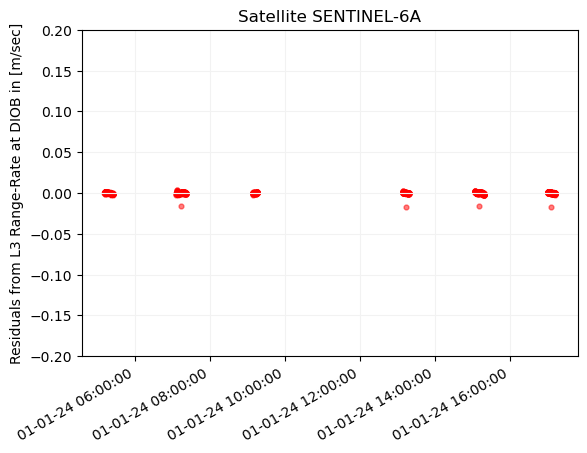

In [9]:
plt.scatter([at2pt(d['epoch']) for d in raw_doppler], dl, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L3 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.ylim(-.2, .2)
plt.show()

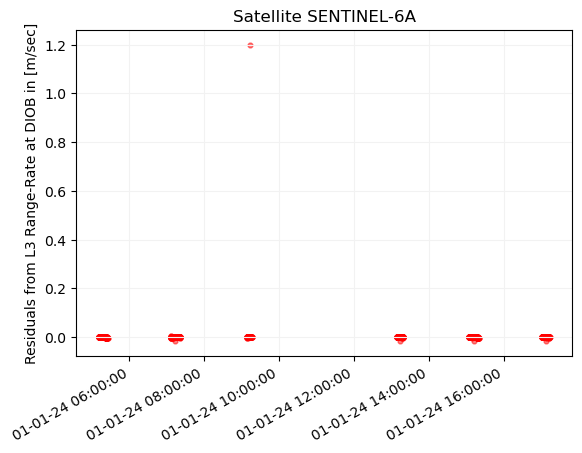

In [10]:
plt.scatter([at2pt(d['epoch']) for d in raw_doppler], dl, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L3 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()

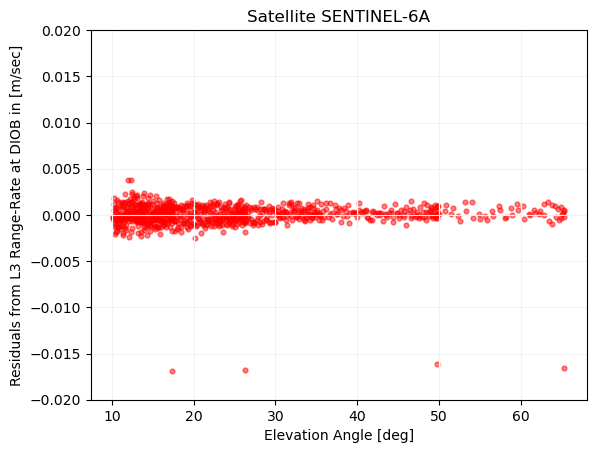

In [12]:
plt.scatter([np.degrees(d['el']) for d in raw_doppler], dl, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L3 Range-Rate at {site_name} in [m/sec]")
plt.xlabel(f"Elevation Angle [deg]")
plt.title(f"Satellite {rnx.sat_name}")
plt.ylim(-.02, .02)
plt.show()